- System 29 from the VADER data set
- 6 months of data

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from time import time
from datetime import datetime
from os.path import expanduser
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TAEAC1031314')
        and meas_name = 'ac_power'
        and ts <= '2016-01-15';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
df = df['ac_power_02']
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

06/26/15 01/13/16
data loading took 2.53 seconds


In [2]:
import cvxpy as cvx

In [3]:
p = df.loc[start:end].values
D = df.loc[start:end].values.reshape(288, -1, order='F')[:, :365//2]

In [4]:
D.shape

(288, 182)

In [5]:
ics = IterativeClearSky(D, k=6)

In [6]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.mu_C = 0.05
ics.tau = 0.9
ics.minimize_objective(max_iter=14)

starting at 217066.886 [523.0487620172614, 360.4097099908434, 216183.42729078242, 0]
iteration 1: 353.515 [264.467   7.712  81.336   0.   ]
iteration 2: 306.789 [210.941  12.152  83.696   0.   ]
iteration 3: 294.777 [195.032  15.484  84.261   0.   ]
iteration 4: 291.510 [189.011  17.802  84.698   0.   ]
iteration 5: 290.367 [186.701  18.975  84.69    0.   ]
iteration 6: 289.819 [185.927  19.336  84.556   0.   ]
iteration 7: 289.602 [185.629  19.484  84.488   0.   ]
Minimization complete in 0.44 minutes


(0, 1728)

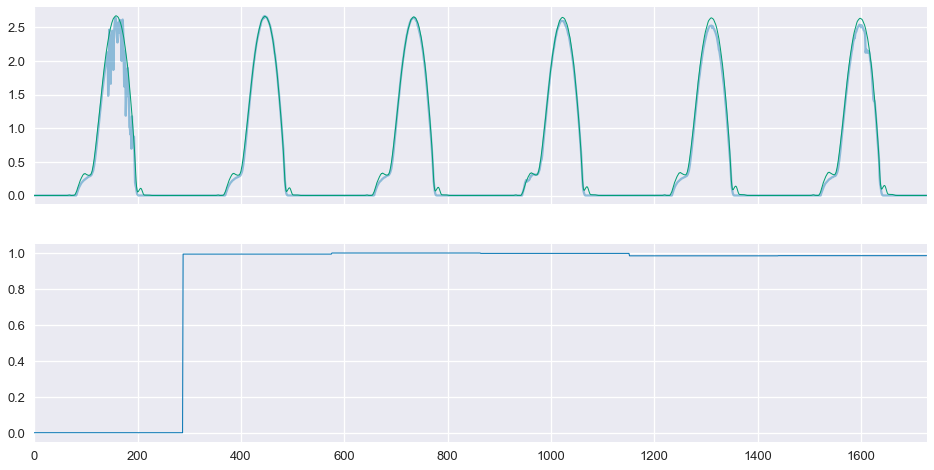

In [7]:
D1 = 170
D2 = D1 + 6
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[-1].set_xlim(0, 288*(D2-D1))

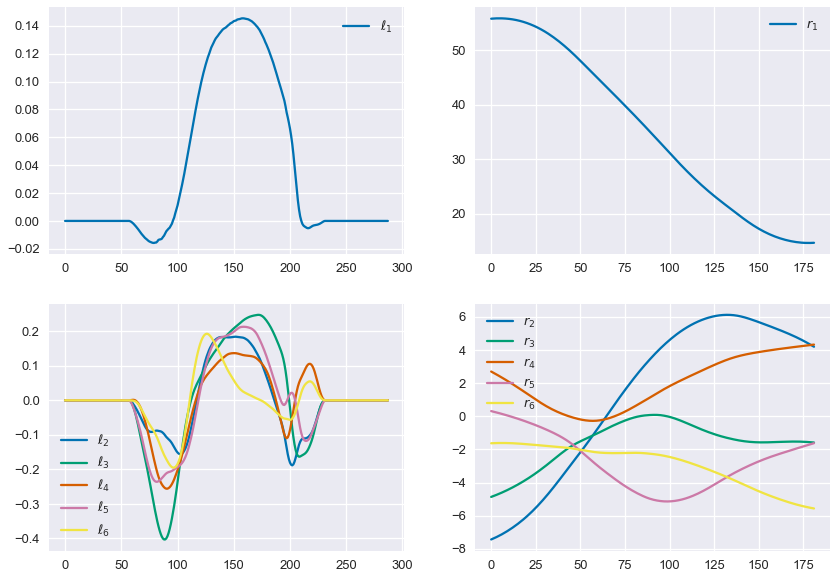

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0].T)
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

[58 49 17 98 64]


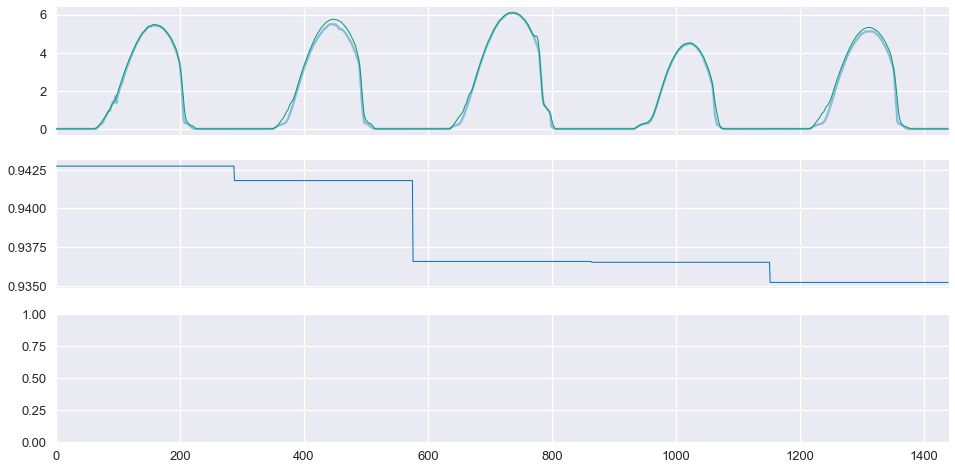

In [9]:
sorted_days = np.argsort(-ics.weights)
D1 = 20
D2 = D1 + 5
print(sorted_days[D1:D2])
actual = D[:, sorted_days[D1:D2]].ravel(order='F')
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, sorted_days[D1:D2]].ravel(order='F')
fig, ax = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[-1].set_xlim(0, 288*(D2-D1))
ax[1].plot(np.repeat(ics.weights[sorted_days[D1:D2]], 288), linewidth=1)
plt.show()

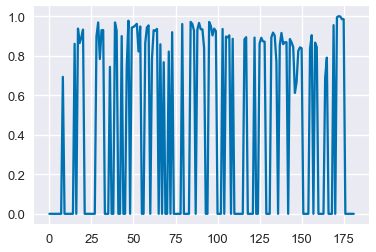

In [10]:
plt.plot(ics.weights)

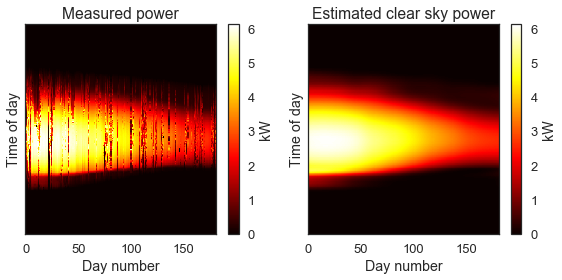

In [11]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[0].set_xlabel('Day number')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

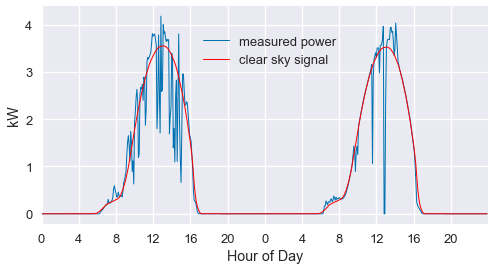

In [12]:
D1 = 130
D2 = D1 + 2
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [13]:
print(sum(ics.L_cs.size) + sum(ics.R_cs.size))

TypeError: 'numpy.int64' object is not iterable

In [ ]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(D, cmap='hot')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')

In [ ]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(D), interpolation='none')
    plt.colorbar(label='kW')
    plt.title('Estimated clear sky power, in matrix form')